In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [63]:
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=30, batch_size=1024, verbose=2, **fit_params):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.fit_params = fit_params
        self.model_ = None
        self.history_ = None

    def fit(self, X, y, **kwargs):
        # Build the model using the provided build function
        self.model_ = self.build_fn()
        # Combine default fit parameters with additional keyword arguments
        fit_params = {**self.fit_params, **kwargs}
        # Remove epochs and batch_size from fit_params to avoid duplication
        fit_params.pop('epochs', None)
        fit_params.pop('batch_size', None)
        # Train the model and store the history
        self.history_ = self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, **fit_params)
        return self

    def predict(self, X):
        # Predict class labels
        return (self.model_.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        # Predict class probabilities
        return self.model_.predict(X)

    def save(self, filepath):
        # Save the underlying Keras model
        if self.model_ is not None:
            self.model_.save(filepath)
        else:
            raise ValueError("Model has not been built yet.")

In [2]:
df=pd.read_pickle("../LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df = df.drop(['waferIndex'], axis = 1)

In [3]:
# 웨이퍼맵의 크기측정
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
87201,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",939.0,lot6222,6.0,[],[],"(39, 31)"
424877,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1724.0,lot25479,20.0,[],[],"(50, 43)"
774745,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1442.0,lot46049,22.0,[[Test]],[[none]],"(41, 45)"
191211,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot12125,10.0,[],[],"(26, 26)"
618515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot38808,23.0,[],[],"(33, 33)"


In [69]:
df['waferMap'][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [6]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

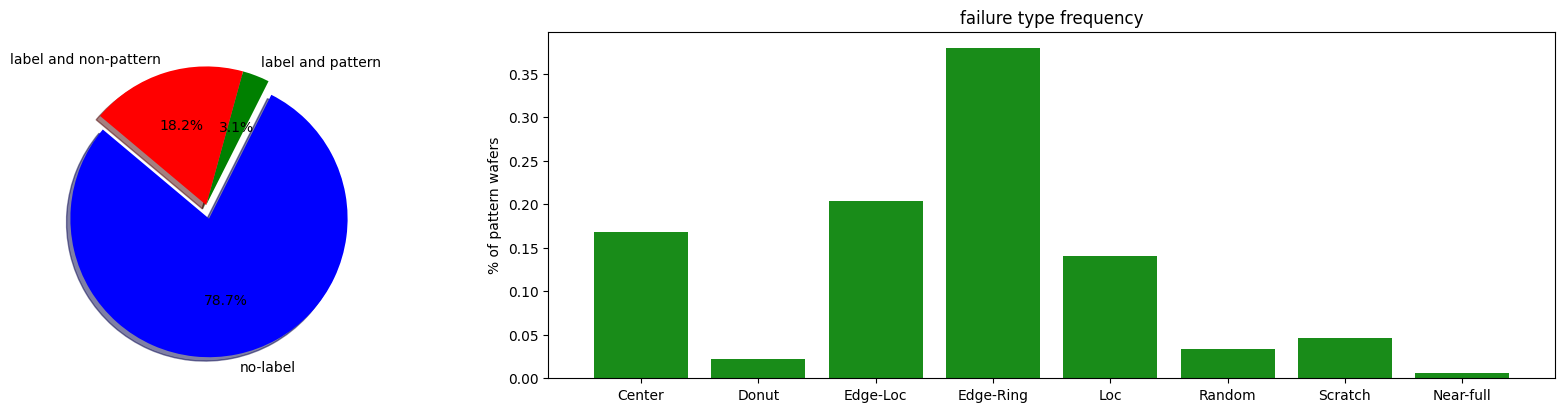

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [4]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [11]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


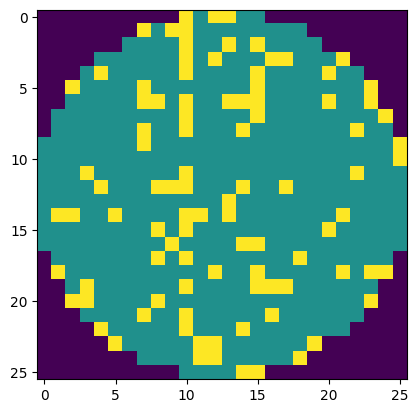

Faulty case : ['none'] 


In [12]:
# plot 1st data
plt.imshow(x[100])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[100]))

In [13]:
x = x.reshape((-1, 26, 26, 1))

In [14]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [15]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [16]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [17]:
new_x.shape

(14366, 26, 26, 3)

In [18]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [19]:
epoch=30
batch_size=1024

In [20]:
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 3s - 191ms/step - loss: 0.1543
Epoch 2/30
15/15 - 2s - 140ms/step - loss: 0.0966
Epoch 3/30
15/15 - 2s - 141ms/step - loss: 0.0834
Epoch 4/30
15/15 - 2s - 142ms/step - loss: 0.0716
Epoch 5/30
15/15 - 2s - 135ms/step - loss: 0.0620
Epoch 6/30
15/15 - 2s - 134ms/step - loss: 0.0550
Epoch 7/30
15/15 - 2s - 143ms/step - loss: 0.0494
Epoch 8/30
15/15 - 2s - 137ms/step - loss: 0.0444
Epoch 9/30
15/15 - 2s - 135ms/step - loss: 0.0394
Epoch 10/30
15/15 - 2s - 134ms/step - loss: 0.0348
Epoch 11/30
15/15 - 2s - 139ms/step - loss: 0.0310
Epoch 12/30
15/15 - 2s - 137ms/step - loss: 0.0278
Epoch 13/30
15/15 - 2s - 134ms/step - loss: 0.0251
Epoch 14/30
15/15 - 2s - 136ms/step - loss: 0.0228
Epoch 15/30
15/15 - 2s - 132ms/step - loss: 0.0208
Epoch 16/30
15/15 - 2s - 138ms/step - loss: 0.0191
Epoch 17/30
15/15 - 2s - 133ms/step - loss: 0.0177
Epoch 18/30
15/15 - 2s - 137ms/step - loss: 0.0164
Epoch 19/30
15/15 - 2s - 136ms/step - loss: 0.0153
Epoch 20/30
15/15 - 2s - 135ms/step - lo

In [21]:
encoder = models.Model(input_tensor, latent_vector)

In [22]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [23]:
encoded_x = encoder.predict(new_x)

449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step


In [24]:
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

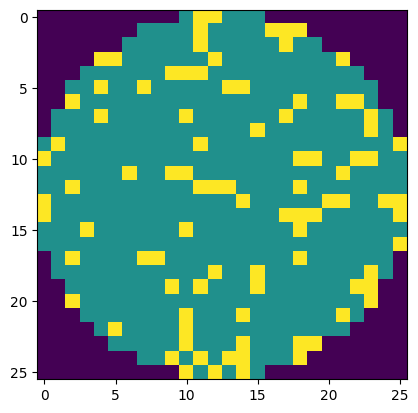

In [25]:
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


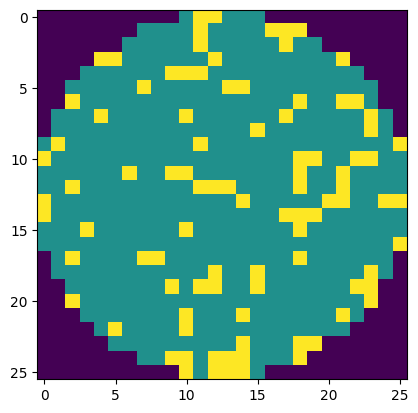

In [26]:
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [27]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [28]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [29]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [30]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [31]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [32]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [33]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [34]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [35]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [46]:
from tensorflow.keras.models import load_model

# 모델 파일 경로
model_path = 'wafer defect classification.keras'

# 모델 불러오기
model = load_model(model_path)

In [62]:
# 예측 수행
predictions = model.predict(random_samples)

# 클래스 레이블 정의
class_labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']

# 예측 결과 디코딩
decoded_predictions = [class_labels[np.argmax(pred)] for pred in predictions]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [63]:
decoded_predictions

['Center', 'Edge-Ring', 'Loc', 'Loc', 'none']

In [57]:
import random

# 랜덤으로 5개의 인덱스를 선택
random_indices = random.sample(range(len(new_x)), 5)

# 선택된 인덱스의 데이터 추출
random_samples = new_x[random_indices]

# 데이터 프레임으로 변환
random_samples_df = pd.DataFrame({'waferMap': [sample for sample in random_samples]})

# CSV 파일로 저장
random_samples_df.to_csv('random_samples.csv', index=False)

In [48]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [49]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [50]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


In [101]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [102]:
model = CustomKerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2)
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
9/9 - 8s - 889ms/step - accuracy: 0.3203 - loss: 2.0744
Epoch 2/30
9/9 - 7s - 791ms/step - accuracy: 0.6893 - loss: 0.8890
Epoch 3/30
9/9 - 7s - 799ms/step - accuracy: 0.8393 - loss: 0.4559
Epoch 4/30
9/9 - 7s - 821ms/step - accuracy: 0.9097 - loss: 0.2704
Epoch 5/30
9/9 - 7s - 823ms/step - accuracy: 0.9484 - loss: 0.1669
Epoch 6/30
9/9 - 7s - 813ms/step - accuracy: 0.9763 - loss: 0.0925
Epoch 7/30
9/9 - 23s - 3s/step - accuracy: 0.9889 - loss: 0.0528
Epoch 8/30
9/9 - 8s - 886ms/step - accuracy: 0.9949 - loss: 0.0297
Epoch 9/30
9/9 - 8s - 853ms/step - accuracy: 0.9971 - loss: 0.0180
Epoch 10/30
9/9 - 8s - 839ms/step - accuracy: 0.9974 - loss: 0.0134
Epoch 11/30
9/9 - 7s - 820ms/step - accuracy: 0.9988 - loss: 0.0098
Epoch 12/30
9/9 - 7s - 792ms/step - accuracy: 0.9981 - loss: 0.0122
Epoch 13/30
9/9 - 7s - 793ms/step - accuracy: 0.9987 - loss: 0.0067
Epoch 14/30
9/9 - 7s - 779ms/step - accuracy: 0.9987 - loss: 0.0081
Epoch 15/30
9/9 - 7s - 799ms/step - accuracy: 0.9984 - loss

In [110]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test]
         )

Epoch 1/30
13/13 - 14s - 1s/step - accuracy: 0.3426 - loss: 2.2090 - val_accuracy: 0.7142 - val_loss: 1.0055
Epoch 2/30
13/13 - 12s - 952ms/step - accuracy: 0.6866 - loss: 0.9120 - val_accuracy: 0.7043 - val_loss: 0.7422
Epoch 3/30
13/13 - 12s - 958ms/step - accuracy: 0.8041 - loss: 0.5600 - val_accuracy: 0.8660 - val_loss: 0.3926
Epoch 4/30
13/13 - 12s - 959ms/step - accuracy: 0.9100 - loss: 0.2862 - val_accuracy: 0.9306 - val_loss: 0.2163
Epoch 5/30
13/13 - 12s - 926ms/step - accuracy: 0.9584 - loss: 0.1440 - val_accuracy: 0.9699 - val_loss: 0.1209
Epoch 6/30
13/13 - 12s - 924ms/step - accuracy: 0.9835 - loss: 0.0668 - val_accuracy: 0.9876 - val_loss: 0.0531
Epoch 7/30
13/13 - 12s - 917ms/step - accuracy: 0.9948 - loss: 0.0297 - val_accuracy: 0.9869 - val_loss: 0.0453
Epoch 8/30
13/13 - 12s - 960ms/step - accuracy: 0.9965 - loss: 0.0191 - val_accuracy: 0.9887 - val_loss: 0.0391
Epoch 9/30
13/13 - 12s - 951ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 0.9901 - val_loss: 0.

In [111]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Testing Accuracy: 0.991866028708134


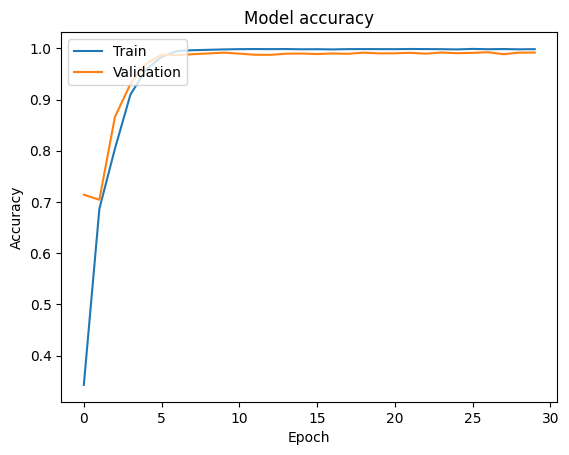

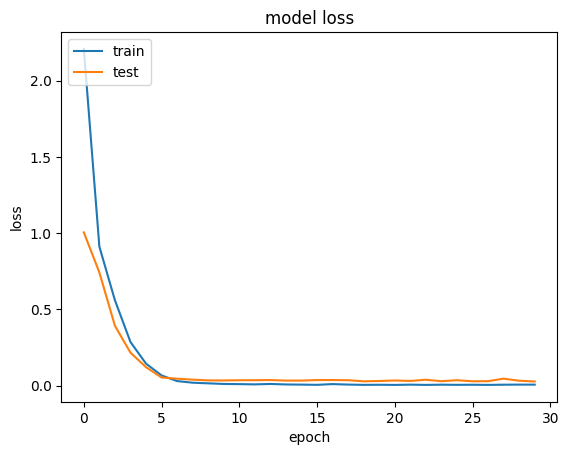

In [116]:
# accuracy plot 
plt.plot(model.history_.history['accuracy'])
plt.plot(model.history_.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# loss plot
plt.plot(model.history_.history['loss'])
plt.plot(model.history_.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
model.save('wafer defect classification.keras')

In [ ]:
['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random' 'Scratch' 'none']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


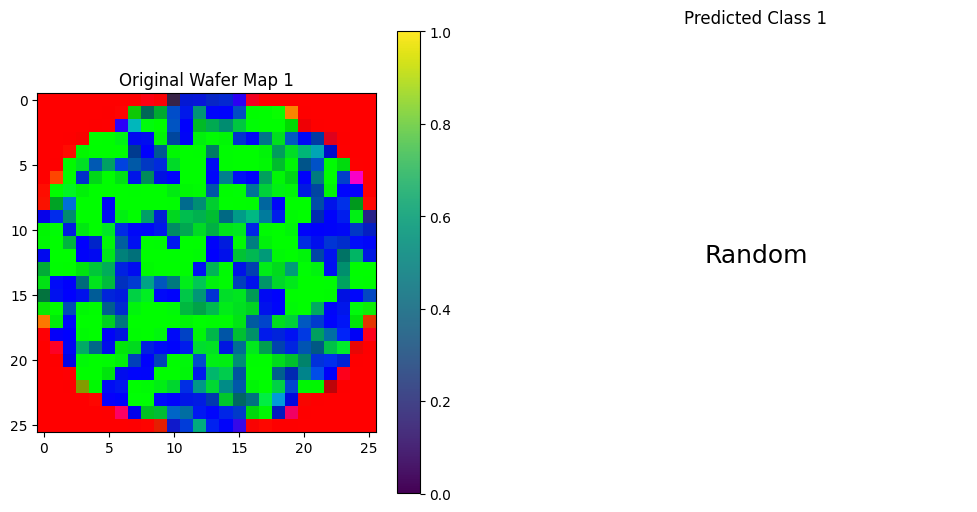

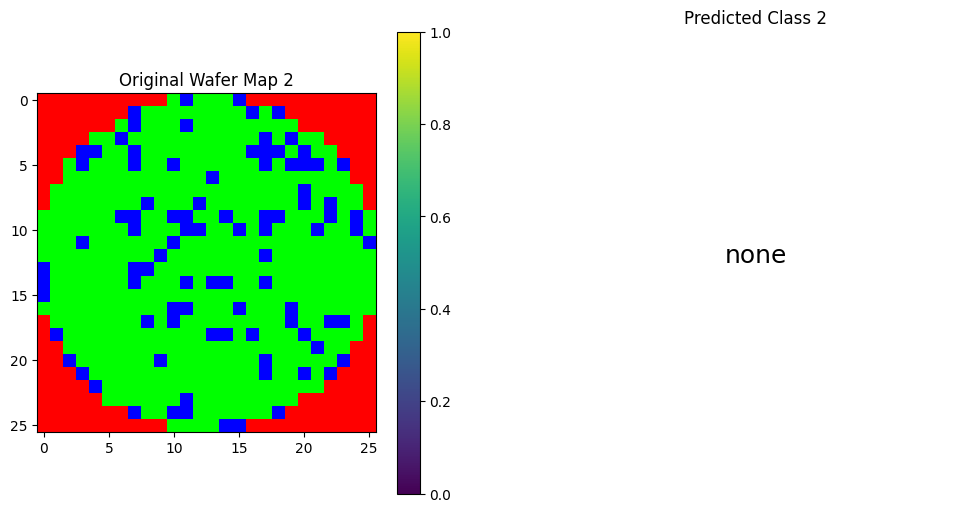

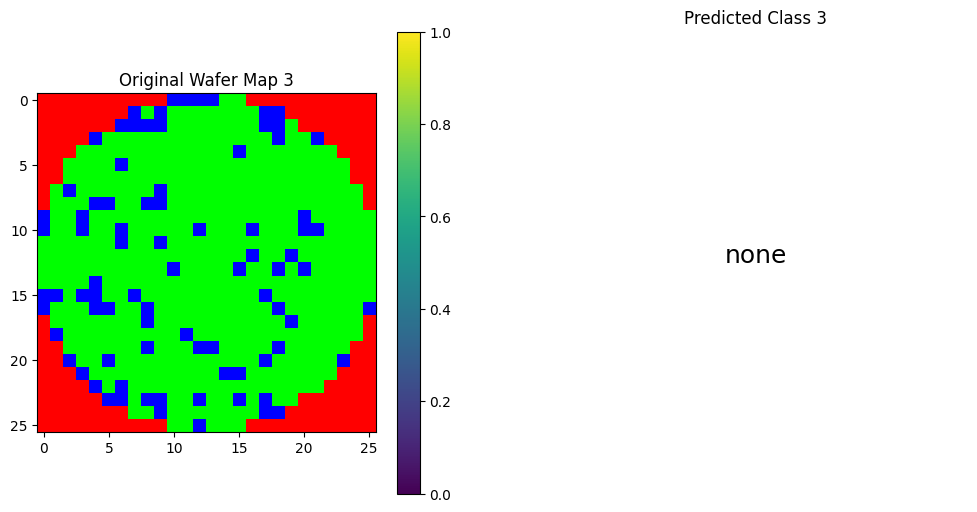

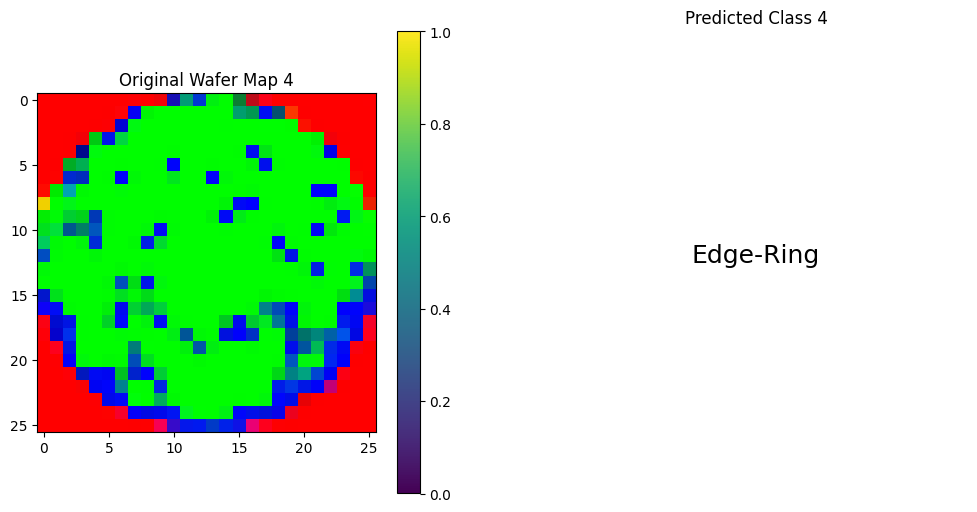

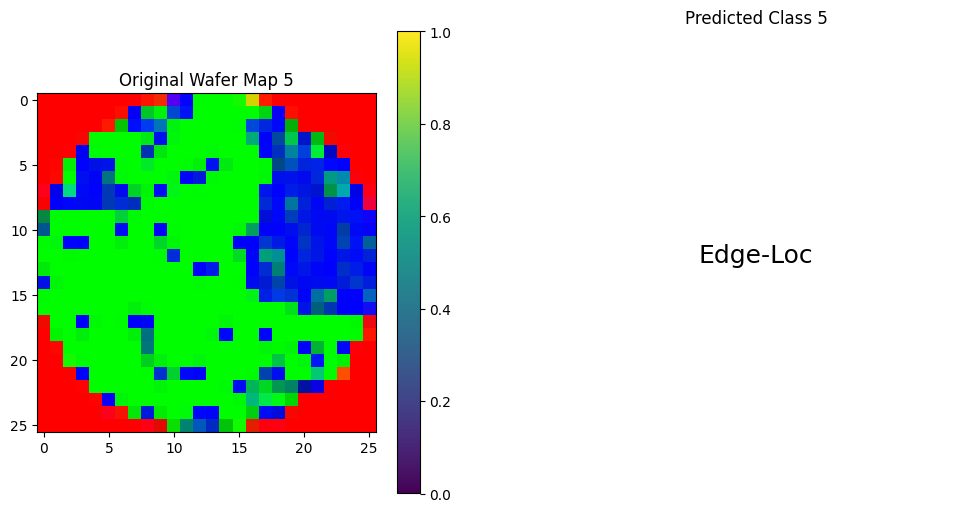

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

num_samples = 5
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)
x_sample = x_test[sample_indices]
y_sample = y_test[sample_indices]

# 모델 로드
model = load_model('wafer defect classification.keras')

# 예측 수행
predictions = model.predict(x_sample)

# 클래스 레이블 정의
class_labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']

# 예측 결과 디코딩
decoded_predictions = [class_labels[np.argmax(pred)] for pred in predictions]

# 예측 결과 시각화
for i in range(len(x_sample)):
    plt.figure(figsize=(12, 6))

    # 원본 웨이퍼 맵 시각화
    plt.subplot(1, 2, 1)
    plt.imshow(x_sample[i])
    plt.title(f'Original Wafer Map {i+1}')
    plt.colorbar()

    # 예측된 클래스 레이블 출력
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, decoded_predictions[i], fontsize=18, ha='center')
    plt.title(f'Predicted Class {i+1}')
    plt.axis('off')

    plt.show()

In [141]:
decoded_predictions = [class_labels[np.argmax(pred)] for pred in y_sample]
decoded_predictions

['Random', 'none', 'none', 'Edge-Ring', 'Edge-Loc']